In [198]:
import numpy as np
from imutils.object_detection import non_max_suppression
import cv2
import pytesseract as pt
import matplotlib
import pandas as pd
from matplotlib import pyplot as plt

In [199]:
#reading image and resizing 
img=cv2.imread('sample/bills/dataset2/9.jpg')[10:650]
#east requires images sizes in multiples of 32
y=int(img.shape[0]/32)*32
x=int(img.shape[1]/32)*32
img=cv2.resize(img,(int(x),int(y)))
print(y,x,img.shape[0],img.shape[1])
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#bw2=cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 2)
#bw=cv2.threshold(gray,0,255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)[1]

640 2016 640 2016


In [200]:
dpi = matplotlib.rcParams['figure.dpi']
figsize=img.shape[1]/dpi,img.shape[0]/dpi

In [201]:
#fn to convert from east detection rotated bounding boxes to regular bounding boxes- got from pyImageSearch 
def decode_predictions(scores, geometry,minConfidence):
	# grab the number of rows and columns from the scores volume, then
	# initialize our set of bounding box rectangles and corresponding
	# confidence scores
	(numRows, numCols) = scores.shape[2:4]
	rects = []
	confidences = []
 
	# loop over the number of rows
	for y in range(0, numRows):
		# extract the scores (probabilities), followed by the
		# geometrical data used to derive potential bounding box
		# coordinates that surround text
		scoresData = scores[0, 0, y]
		xData0 = geometry[0, 0, y]
		xData1 = geometry[0, 1, y]
		xData2 = geometry[0, 2, y]
		xData3 = geometry[0, 3, y]
		anglesData = geometry[0, 4, y]
 
		# loop over the number of columns
		for x in range(0, numCols):
			# if our score does not have sufficient probability,
			# ignore it
			if scoresData[x] < minConfidence:
				continue
 
			# compute the offset factor as our resulting feature
			# maps will be 4x smaller than the input image
			(offsetX, offsetY) = (x * 4.0, y * 4.0)
 
			# extract the rotation angle for the prediction and
			# then compute the sin and cosine
			angle = anglesData[x]
			cos = np.cos(angle)
			sin = np.sin(angle)
 
			# use the geometry volume to derive the width and height
			# of the bounding box
			h = xData0[x] + xData2[x]
			w = xData1[x] + xData3[x]
 
			# compute both the starting and ending (x, y)-coordinates
			# for the text prediction bounding box
			endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
			endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
			startX = int(endX - w)
			startY = int(endY - h)
 
			# add the bounding box coordinates and probability score
			# to our respective lists
			rects.append((startX, startY, endX, endY))
			confidences.append(scoresData[x])
 
	# return a tuple of the bounding boxes and associated confidences
	return (rects, confidences)

In [202]:
def returnContours(mask):
    cnts=cv2.findContours(mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[0]
    rects=[cv2.boundingRect(cnt) for cnt in cnts]
    rects=np.array([[x,y,x+w,y+h] for x,y,w,h in rects])
    return rects

In [203]:
def drawRects(rects,img):
    for x1,y1,x2,y2 in rects:
        cv2.rectangle(img,(x1,y1),(x2,y2),(0,255,0),3)
    

In [204]:
#Text detection and getting bounding boxes
meanRGB=(123.68, 116.78, 103.94)
h,w=img.shape[:2]
blob=cv2.dnn.blobFromImage(img,1.0,(w,h),meanRGB,swapRB=True,crop=False)

layerNames = ["feature_fusion/Conv_7/Sigmoid","feature_fusion/concat_3"]
net=cv2.dnn.readNet('ML/nets/frozen_east_text_detection.pb')

net.setInput(blob)
scores,locs=net.forward(layerNames)

#getting bounding rects from east's output
rects,conf=decode_predictions(scores,locs,0.3)
rects=non_max_suppression(np.array(rects), probs=conf)

In [205]:
#generating mask of detected text
black=np.zeros((img.shape[0],img.shape[1]),dtype=np.uint8)
mask=black.copy()
for x1,y1,x2,y2 in rects:
    mask[max(0,y1):min(mask.shape[0],y2),max(0,x1):min(mask.shape[1],x2)]=255


In [206]:
kernel_head=np.ones((5,10),np.uint8)
blob_mask=cv2.dilate(mask.copy(),kernel_head)

blobs=returnContours(blob_mask)

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
[1270   16 1350   46]
4


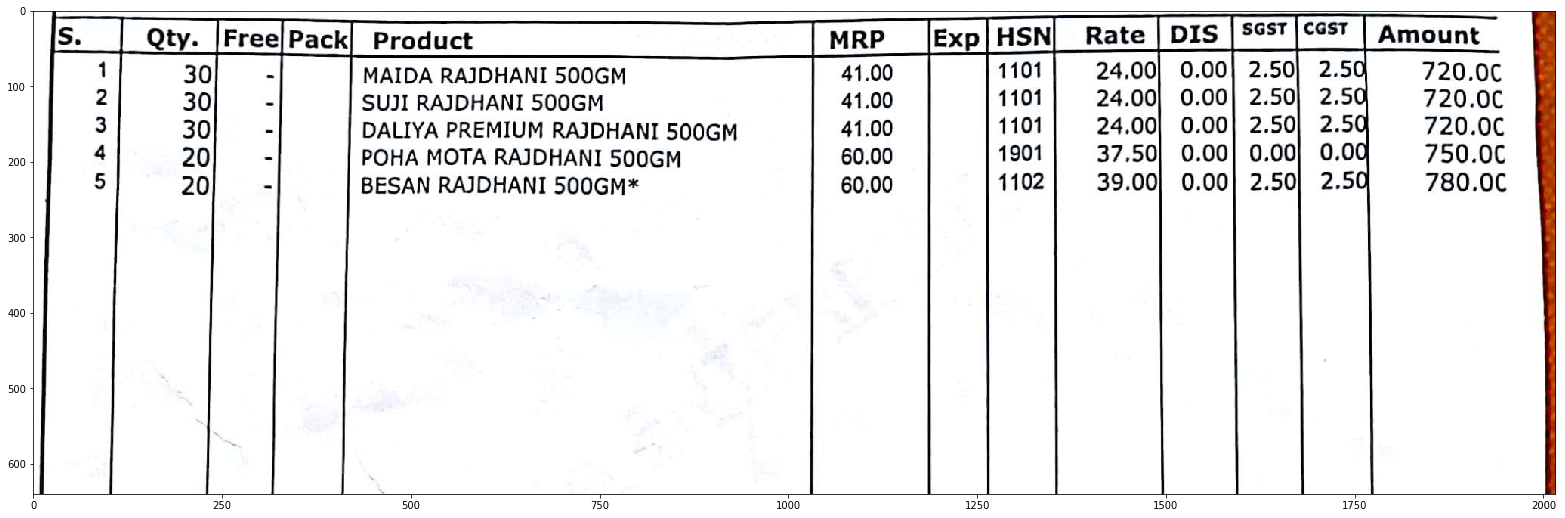

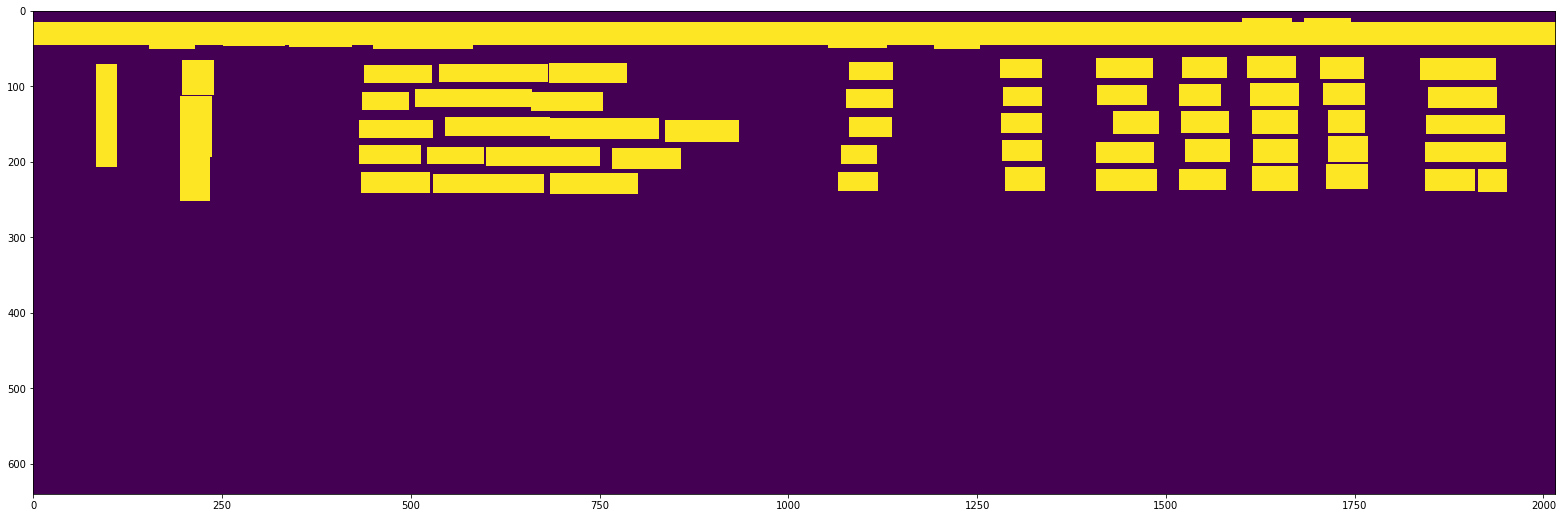

In [245]:
#finding heading threshold

discard=np.where(rects<0)
print(discard)
rects=np.delete(rects,discard,axis=0)
print(np.where(rects<0))

#top= rects[np.argsort(rects[:,1])[2]]
top= rects[np.argsort(rects[:,1])[2]]

print(top)
#topline=np.zeros((img.shape[0],img.shape[1]),dtype=np.uint8)
topline=mask.copy()
x1,y1,x2,y2=top
topline[y1:y2,:]=255

blobs_grouped=returnContours(topline)

heading=blobs_grouped[np.argmin(blobs_grouped[:,1])]
print(len(heading))
temp=img.copy()
#drawRects([top],temp)
#drawRects([heading],temp)
drawRects(rects,temp)
fig = plt.figure(figsize=figsize)
plt.imshow(img)

fig = plt.figure(figsize=figsize)
plt.imshow(topline)


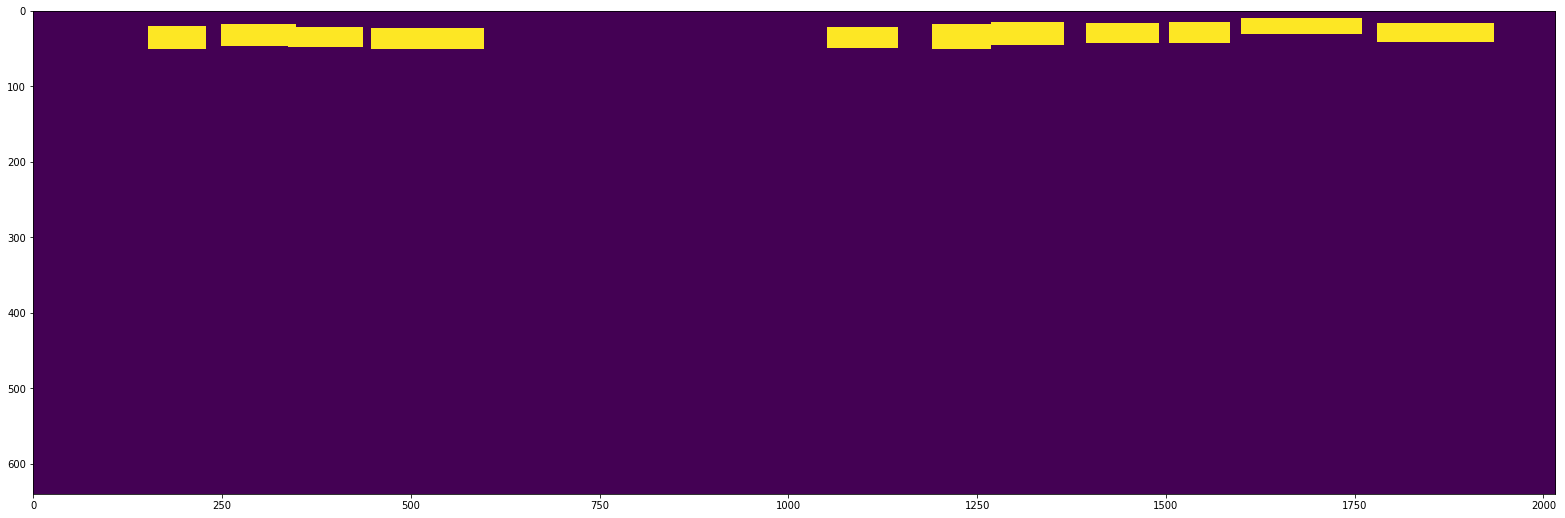

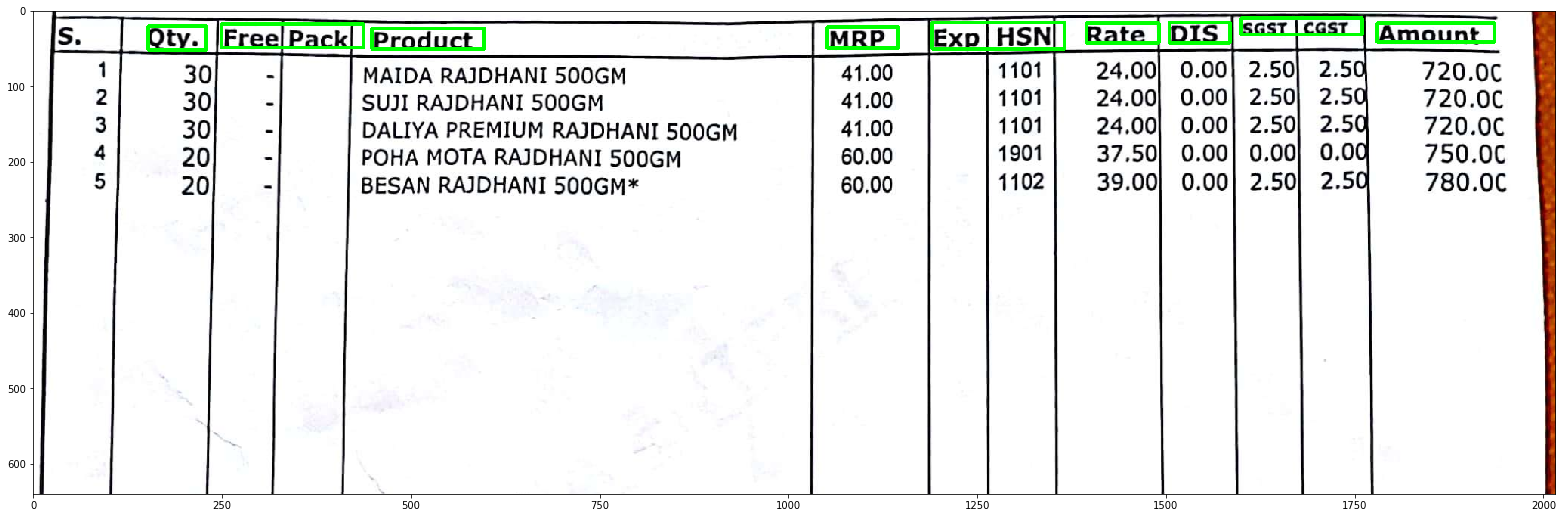

In [208]:
y_heading=heading[3]
heads=[]
non_heads=[]
for x1,y1,x2,y2 in rects:
    heads.append([x1,y1,x2+3,y2])if((y2+y1)/2<=y_heading) else non_heads.append([x1,y1,x2,y2])

heads_mask=black.copy()
for x1,y1,x2,y2 in heads:
    heads_mask[y1:y2,x1:x2+10]=255
    
merge_words=np.ones((1,5),dtype=np.uint8)
heads_mask=cv2.dilate(heads_mask,merge_words)
heads=returnContours(heads_mask)


fig=plt.figure(figsize=figsize)
plt.imshow(heads_mask)


temp=img.copy()
drawRects(heads,temp)
fig = plt.figure(figsize=figsize)
plt.imshow(temp)

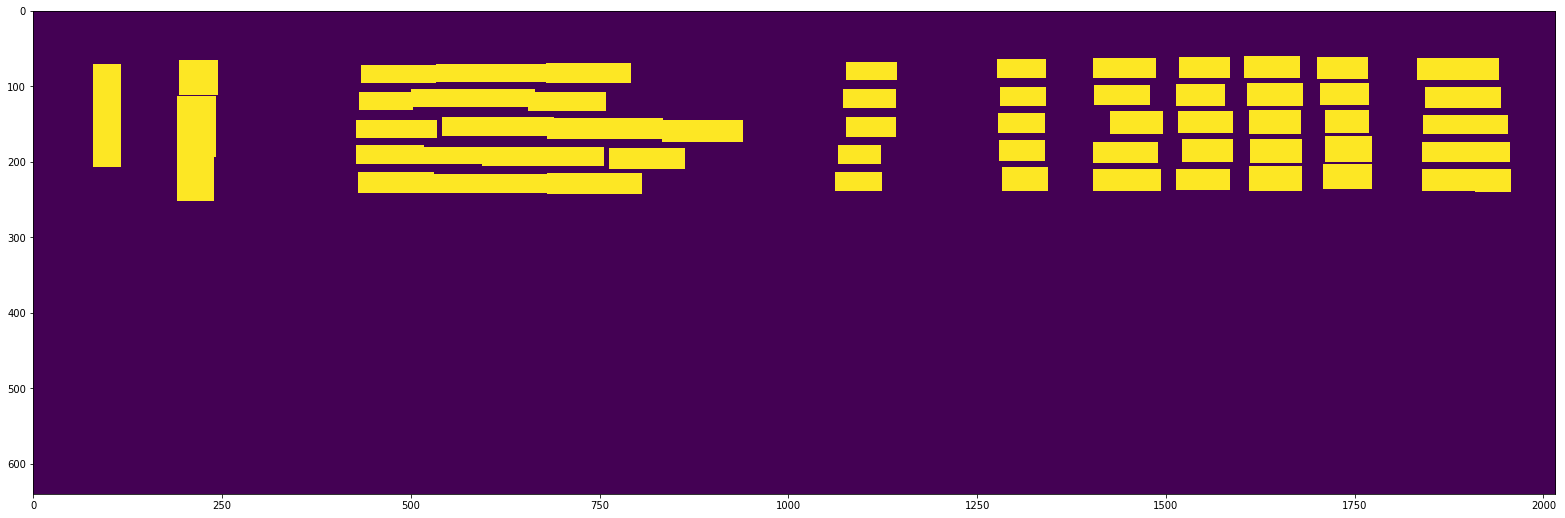

In [209]:

nh_mask=black.copy()
for x1,y1,x2,y2 in non_heads:
    nh_mask[y1:y2,x1:x2]=255

merge=np.ones((1,10),dtype=np.uint8)
nh_mask=cv2.dilate(nh_mask,merge)
non_heads_merged=returnContours(nh_mask)

temp2=img.copy()
drawRects(non_heads_merged,temp2)
fig=plt.figure(figsize=figsize)
plt.imshow(nh_mask)



In [210]:
'''
x_heads=np.array([(x1+x2)/2 for x1,y1,x2,y2 in heads])
x_nhs=np.array([(x1+x2)/2 for x1,y1,x2,y2 in non_heads_merged])

nh_map=[]
for i in range(len(x_heads)):
    nh_map.append([])

print(x_heads)
for i,x_nh in enumerate(x_nhs):
    dst=np.abs(x_nh-x_heads)
    nh_map[np.argmin(dst)].append(non_heads_merged[i])

map_plot=img.copy()
for hds in nh_map:
    col=np.random.randint(0,255,(1,3))[0].astype('int')
    col = ( int (col [ 0 ]), int (col[ 1 ]), int (col[ 2 ]))
    for x1,y1,x2,y2 in hds: cv2.rectangle(map_plot,(x1,y1),(x2,y2),col,3)
    
fig=plt.figure(figsize=figsize)
plt.imshow(map_plot)
'''

"\nx_heads=np.array([(x1+x2)/2 for x1,y1,x2,y2 in heads])\nx_nhs=np.array([(x1+x2)/2 for x1,y1,x2,y2 in non_heads_merged])\n\nnh_map=[]\nfor i in range(len(x_heads)):\n    nh_map.append([])\n\nprint(x_heads)\nfor i,x_nh in enumerate(x_nhs):\n    dst=np.abs(x_nh-x_heads)\n    nh_map[np.argmin(dst)].append(non_heads_merged[i])\n\nmap_plot=img.copy()\nfor hds in nh_map:\n    col=np.random.randint(0,255,(1,3))[0].astype('int')\n    col = ( int (col [ 0 ]), int (col[ 1 ]), int (col[ 2 ]))\n    for x1,y1,x2,y2 in hds: cv2.rectangle(map_plot,(x1,y1),(x2,y2),col,3)\n    \nfig=plt.figure(figsize=figsize)\nplt.imshow(map_plot)\n"

In [211]:
'''
config='--psm 6'
txts=[]
for x1,y1,x2,y2 in heads:
        crop=img[max(0,y1-2):min(img.shape[0],y2+2),max(0,x1-2):min(img.shape[1],x2+2)].copy()
        txt=pt.image_to_string(crop,config=config)
        print(txt)
        txts.append(txt)
prodId=txts.index('DESCRIPTION')
prods=img.copy()
drawRects(nh_map[prodId],prods)
fig=plt.figure(figsize=figsize)
plt.imshow(prods)
'''

"\nconfig='--psm 6'\ntxts=[]\nfor x1,y1,x2,y2 in heads:\n        crop=img[max(0,y1-2):min(img.shape[0],y2+2),max(0,x1-2):min(img.shape[1],x2+2)].copy()\n        txt=pt.image_to_string(crop,config=config)\n        print(txt)\n        txts.append(txt)\nprodId=txts.index('DESCRIPTION')\nprods=img.copy()\ndrawRects(nh_map[prodId],prods)\nfig=plt.figure(figsize=figsize)\nplt.imshow(prods)\n"

In [212]:
'''
prod_mask=black.copy()
for x1,y1,x2,y2 in nh_map[prodId]:
    prod_mask[y1:y2,x1:x2+10]=255
    
#prodkern=np.ones()
fig=plt.figure(figsize=figsize)
plt.imshow(prod_mask)
'''

'\nprod_mask=black.copy()\nfor x1,y1,x2,y2 in nh_map[prodId]:\n    prod_mask[y1:y2,x1:x2+10]=255\n    \n#prodkern=np.ones()\nfig=plt.figure(figsize=figsize)\nplt.imshow(prod_mask)\n'

In [213]:
'''
headings_mask=black.copy()
for x1,y1,x2,y2 in heads:
    headings_mask[y1:y2,x1:x2+10]=255
    
kernel=np.ones((55,1),np.uint8)
headings_mask=cv2.dilate(headings_mask.copy(),kernel)

fig=plt.figure(figsize=figsize)
plt.imshow(headings_mask)
'''

'\nheadings_mask=black.copy()\nfor x1,y1,x2,y2 in heads:\n    headings_mask[y1:y2,x1:x2+10]=255\n    \nkernel=np.ones((55,1),np.uint8)\nheadings_mask=cv2.dilate(headings_mask.copy(),kernel)\n\nfig=plt.figure(figsize=figsize)\nplt.imshow(headings_mask)\n'

<Figure size 2016x640 with 0 Axes>

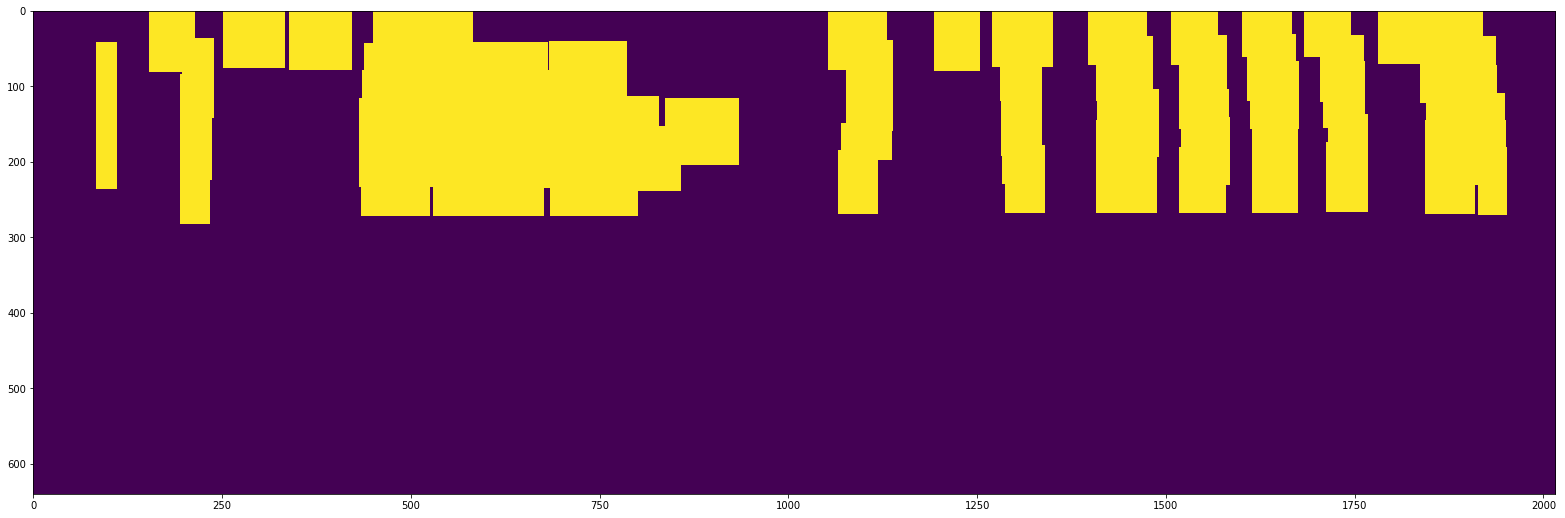

In [214]:
#mask1=cv2.bitwise_or(prod_mask,mask)
#mask1=cv2.bitwise_or(mask1,headings_mask)
fig=plt.figure(figsize=figsize)
#plt.imshow(mask1)

kernel=np.ones((60,1),np.uint8)
mask2=cv2.dilate(mask.copy(),kernel)

fig=plt.figure(figsize=figsize)
plt.imshow(mask2)

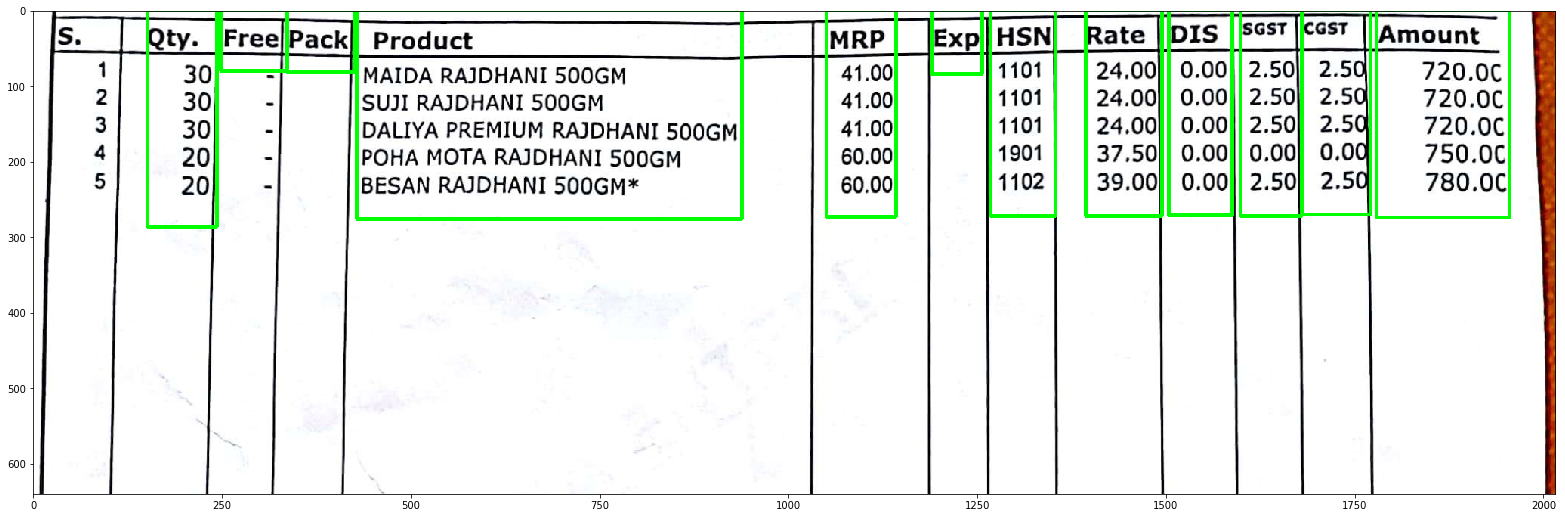

In [218]:
cnts=cv2.findContours(mask2,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[0]
batches=[cv2.boundingRect(cnt) for cnt in cnts]
avg_area=np.mean([w*h for x,y,w,h in batches])
batches=np.array([[max(0,x-3),max(0,y),min(img.shape[1],x+w+3),min(img.shape[0],y+h+3)] for x,y,w,h in batches if y<img.shape[0]/5])
batches=batches[np.argsort(batches[:,0])][1:]

batchBox=img.copy()
drawRects(batches,batchBox)
fig=plt.figure(figsize=figsize)
plt.imshow(batchBox)

In [216]:
config='--psm 6'

texts=[]
for x1,y1,x2,y2 in batches:
        crop=img[y1:y2,x1:x2].copy()
        #crop =cv2.resize(crop, None, fx=3, fy=3, interpolation=cv2.INTER_AREA)
        crop =cv2.GaussianBlur(crop,(3,3),0)
        text=pt.image_to_string(crop,lang='eng',config=config)
        text=[txt for txt in text.split('\n') if txt!='']
        texts.append(text)
        print(text)
        print('\n')
        print('\n')


['Free]']




['Pack']




['Product', 'MAIDA RAJDHANI 500GM', 'SUJI RAJDHANI SOOGM', 'DALIYA PREMIUM RAJDHANI 500GM', 'POHA MOTA RAJDHANI S500GM', 'BESAN RAJDHANI 500GM*']




['MRP', '41.00', '41.00', '41.00', '60.00', '60.00']




['Exp']




['HSN', '1101', '1101', '1101', '1901', '4102']




['Rate', '24.00', '24.00', '24.00)', '37.50', '39.00)']




['DIS', '0.00', '0.00', '0.00', '0.00', '0.00']




['SGST', '2.50)', '2.50', '2.50', '0.00', '2.50)']




['cGsT', '2.5', '2.5', '2.5)', '0.0', '2.5']




['Amount_', '720.0¢', '720.0C', '720.0C', '750.0C', '780.0C']






In [244]:
keys=[lis[0] for lis in texts]
keys
data={}
for i,key in enumerate(keys):
    data[key]=texts[i][1:]

df=pd.DataFrame({k : pd.Series(v) for k, v in data.items()})
df.index=np.arange(1,len(df)+1)
df.to_excel('bill_temp/bill10.xlsx')

C:\Users\athar\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  import sys
